## File descriptions

train.csv: Contains 4250 lines with 20 columns. 3652 samples (85.93%) belong to class churn=no and 598 samples (14.07%) belong to class churn=yes

test.csv: Contains 750 lines with 20 columns: the index of each sample and the 19 features (missing the target variable "churn").

## Data fields

* state, string.
 
    2-letter code of the US state of customer residence
* account_length, numerical. 

    Number of months the customer has been with the current telco provider
* area_code, string=

    "area_code_AAA" where AAA = 3 digit area code.
* international_plan, (yes/no). 

    The customer has international plan.
* voice_mail_plan, (yes/no). 

    The customer has voice mail plan.
* number_vmail_messages, numerical.

    Number of voice-mail messages.
* total_day_minutes, numerical. 

    Total minutes of day calls.
* total_day_calls, numerical. 

    Total number of day calls.
* total_day_charge, numerical. 

    Total charge of day calls.
* total_eve_minutes, numerical. 

    Total minutes of evening calls.
* total_eve_calls, numerical. 

    Total number of evening calls.
* total_eve_charge, numerical. 

    Total charge of evening calls.
* total_night_minutes, numerical. 

    Total minutes of night calls.
* total_night_calls, numerical. 

    Total number of night calls.
* total_night_charge, numerical.

    Total charge of night calls.
* total_intl_minutes, numerical. 

    Total minutes of international calls.
* total_intl_calls, numerical. 

    Total number of international calls.
* total_intl_charge, numerical. 

    Total charge of international calls
* number_customer_service_calls, numerical. 

    Number of calls to customer service
* churn, (yes/no). 

    Customer churn - target variable.

In [63]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [3]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

## Descriptive Analytics

[Text(0.5, 0, 'churn'),
 Text(0, 0.5, 'nº observatios'),
 Text(0.5, 1.0, 'Unbalanced classes')]

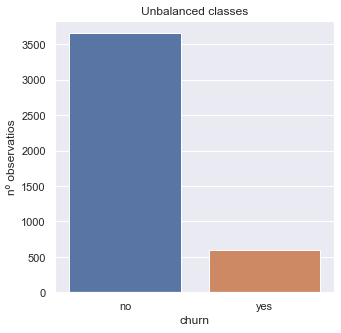

In [53]:
# Unbalance classes
dtp = df.groupby('churn').count()

sns.set(rc={'figure.figsize':(5 , 5)})
ax = sns.barplot(x= dtp.index,
              y= [dtp.iloc[0].max(), dtp.iloc[1].max()])
ax.set(xlabel='churn',
       ylabel='nº observations',
       title = 'Unbalanced classes')

In [69]:
df.groupby('churn')['number_customer_service_calls'].sum()/df['churn'].value_counts()

churn
no     1.441676
yes    2.275920
dtype: float64

[Text(0.5, 0, 'churn'),
 Text(0, 0.5, 'nº observatios'),
 Text(0.5, 1.0, '% customer service calls')]

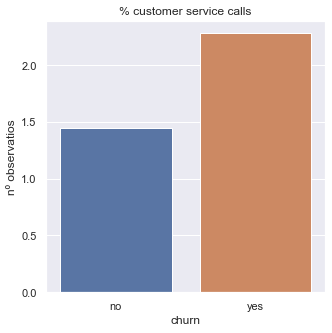

In [75]:
# Customers who churn have made more customer service calls
dtp = df.groupby('churn')['number_customer_service_calls'].sum()/df['churn'].value_counts()

sns.set(rc={'figure.figsize':(5 , 5)})
ax = sns.barplot(x= dtp.index,
            y= dtp.values)
ax.set(xlabel='churn',
       ylabel='nº observations',
       title = '% customer service calls')


In [20]:
# No missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

## Pre Process

In [21]:
def pre_process(df):
    df['international_plan'] = df['international_plan'].map(dict(yes=1, no=0))
    df['area_code'] = df['area_code'].apply(lambda x: int(x.split("_")[2]))
    df['voice_mail_plan'] = df['voice_mail_plan'].map(dict(yes=1, no=0))

    df['state'] = df['state'].factorize()[0]

    return df


## Modelling



In [ ]:
X_train = pre_process(df.drop(columns= 'churn'))
y_train = df['churn'].map(dict(yes=1, no=0))

X_test = pre_process(df_test)

mc = ShuffleSplit(n_splits= 10, test_size=.2, random_state=42)

### XGBOOST

Podria mejorar mucho con down o up sampling. 

In [23]:
# Montecarlo cross-validation
param_grid = {
        'min_child_weight': [3, 6],
        'gamma': [0, 1, 4],
        'subsample': [0.5, 1.0],
        'max_depth': [3, 5]
        }


xgbc = XGBClassifier(objective = "binary:logistic")

grid_search = GridSearchCV(xgbc, param_grid, cv= mc, scoring='balanced_accuracy', verbose = 3, n_jobs= -1)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'gamma': [0, 1, 4], 'max_depth': [3, 5],
                         'min_child_weight': [3, 6], 'subsample': [0.5, 1.0]},
             scoring='balanced_accuracy', verbose=3)

In [24]:
print("best params: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)

best params:  {'gamma': 0, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 1.0}
best score:  0.8827557683504219


### Lightgbm

In [26]:
# Montecarlo cross-validation
mc = ShuffleSplit(n_splits= 10, test_size=.2, random_state=42)


param_grid = {
        'num_leaves': [31, 127],
        'reg_alpha': [0.1, 0.5],
        'min_data_in_leaf': [30, 50, 100],
        'lambda_l1': [0, 1, 1.5],
        'lambda_l2': [0, 1]
        }


lgbmc = lgb.LGBMClassifier(is_unbalance=True, objective = "binary")

grid_search = GridSearchCV(lgbmc, param_grid, cv= mc, scoring='balanced_accuracy', verbose = 3, n_jobs= -1)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=LGBMClassifier(is_unbalance=True, objective='binary'),
             n_jobs=-1,
             param_grid={'lambda_l1': [0, 1, 1.5], 'lambda_l2': [0, 1],
                         'min_data_in_leaf': [30, 50, 100],
                         'num_leaves': [31, 127], 'reg_alpha': [0.1, 0.5]},
             scoring='balanced_accuracy', verbose=3)

In [27]:
print("best params: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)

best params:  {'lambda_l1': 1.5, 'lambda_l2': 1, 'min_data_in_leaf': 50, 'num_leaves': 127, 'reg_alpha': 0.1}
best score:  0.9029769990693917


## Predictions

Competition: https://www.kaggle.com/competitions/customer-churn-prediction-2020/overview

Score: 0.94222

In [31]:
lgbmc = lgb.LGBMClassifier(is_unbalance=True, objective = "binary",
                           lambda_l1 = 1.5, lambda_l2 = 1, min_data_in_leaf = 50,
                           num_leaves = 127, reg_alpha = 0.1)

lgbmc.fit(X_train, y_train)

df_test['churn'] = lgbmc.predict(X_test.drop(columns = 'id'))

In [32]:
df_test['churn'] = df_test['churn'].apply(lambda x: 'yes' if x == 1 else 'no')

In [35]:
df_test[['id', 'churn']].to_csv('submission.csv', index=False)